In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 12
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Data",
    seed=100,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 119 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

- Here we can find the class names in the class_names attribute on these datasets.

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(12, 256, 256, 3)
[0 2 1 2 2 2 1 0 1 0 2 0]


# Observation :
- The image_batch is a tensor of the shape (12, 256, 256, 3).
- This is a batch of 12 images of shape 256x256x3.
- the last dimension refers to color channels RGB.
   

# Data visualization

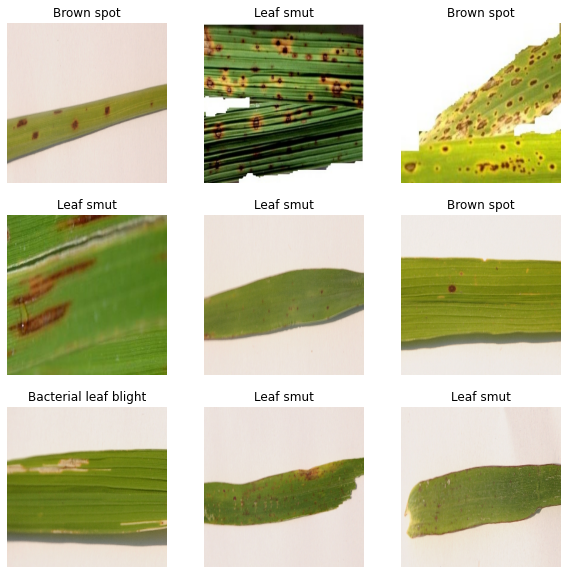

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
len(dataset)

10

In [8]:
train_size = 0.8
len(dataset)*train_size

8.0

In [9]:
train_ds = dataset.take(8)
len(train_ds)

8

In [10]:
test_ds = dataset.skip(8)
len(test_ds)

2

In [11]:
val_size=0.1
len(dataset)*val_size

1.0

In [12]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [13]:
test_ds = test_ds.skip(1)
len(test_ds)

1

In [14]:
# function for spliting the dataset.

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=100):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=100)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
# here, we split the dataset.

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

8

In [17]:
len(val_ds)

1

In [18]:
len(test_ds)

1

# Configure the dataset for performance
- **Dataset.cache** keeps the images in memory after they're loaded off disk during the first epoch
- **Dataset.prefetch** overlaps data preprocessing and model execution while training.

In [19]:
train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

## Data Augmentation

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (12, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (12, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (12, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (12, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (12, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (12, 60, 60, 64)         

# Compiling the Model
- we use **Adam** optimizer and **tf.keras.losses.SparseCategoricalCrossentropy** loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
8/8 [==============================] - 31s 3s/step - loss: 1.1325 - accuracy: 0.2842 - val_loss: 1.1077 - val_accuracy: 0.3333
Epoch 2/50
8/8 [==============================] - 16s 2s/step - loss: 1.0999 - accuracy: 0.3474 - val_loss: 1.1029 - val_accuracy: 0.3333
Epoch 3/50
8/8 [==============================] - 16s 2s/step - loss: 1.0964 - accuracy: 0.3684 - val_loss: 1.0938 - val_accuracy: 0.4167
Epoch 4/50
8/8 [==============================] - 17s 2s/step - loss: 1.0812 - accuracy: 0.4842 - val_loss: 1.0640 - val_accuracy: 0.4167
Epoch 5/50
8/8 [==============================] - 18s 2s/step - loss: 1.0358 - accuracy: 0.5158 - val_loss: 0.9716 - val_accuracy: 0.5000
Epoch 6/50
8/8 [==============================] - 16s 2s/step - loss: 0.9522 - accuracy: 0.5053 - val_loss: 0.9411 - val_accuracy: 0.5833
Epoch 7/50
8/8 [==============================] - 20s 3s/step - loss: 0.9679 - accuracy: 0.5368 - val_loss: 0.7457 - val_accuracy: 0.6667
Epoch 8/50
8/8 [==================

In [27]:
scores = model.evaluate(test_ds)

1/1 [==============================] - 2s 2s/step - loss: 0.5600 - accuracy: 0.8333


In [28]:
model.evaluate(train_ds)

8/8 [==============================] - 6s 656ms/step - loss: 0.2526 - accuracy: 0.8947


[0.2526363134384155, 0.8947368264198303]

- We can see that the train accuracy is 89% and the test accuracy is 83%. It is clear that the model is good fitted.

# Plot training and validation graphs

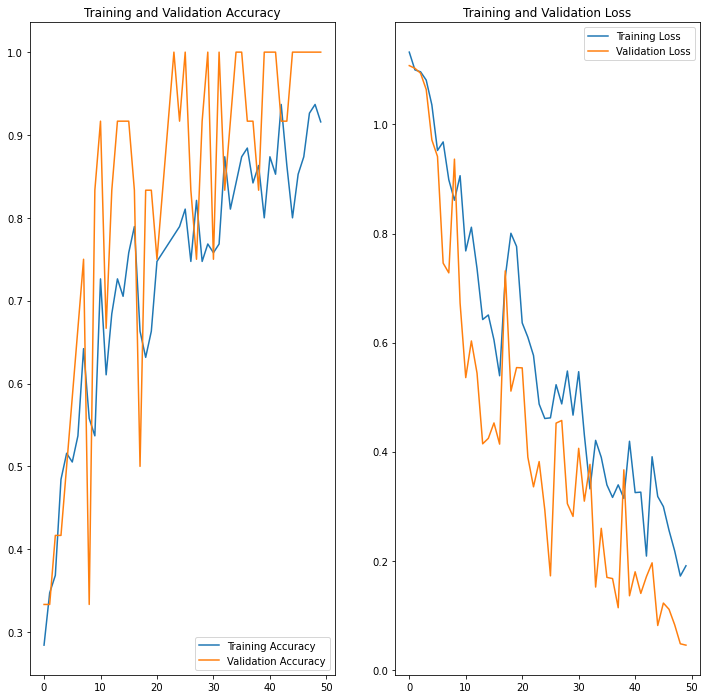

In [29]:

acc = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_accuracy,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training Loss')
plt.plot(epochs_range,val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Run prediction on a sample image

first image to predict
actual label: Leaf smut
1/1 [==============================] - 1s 1s/step
predicted label: Leaf smut


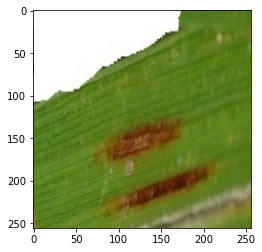

In [30]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Function for inference

In [31]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 100ms/step


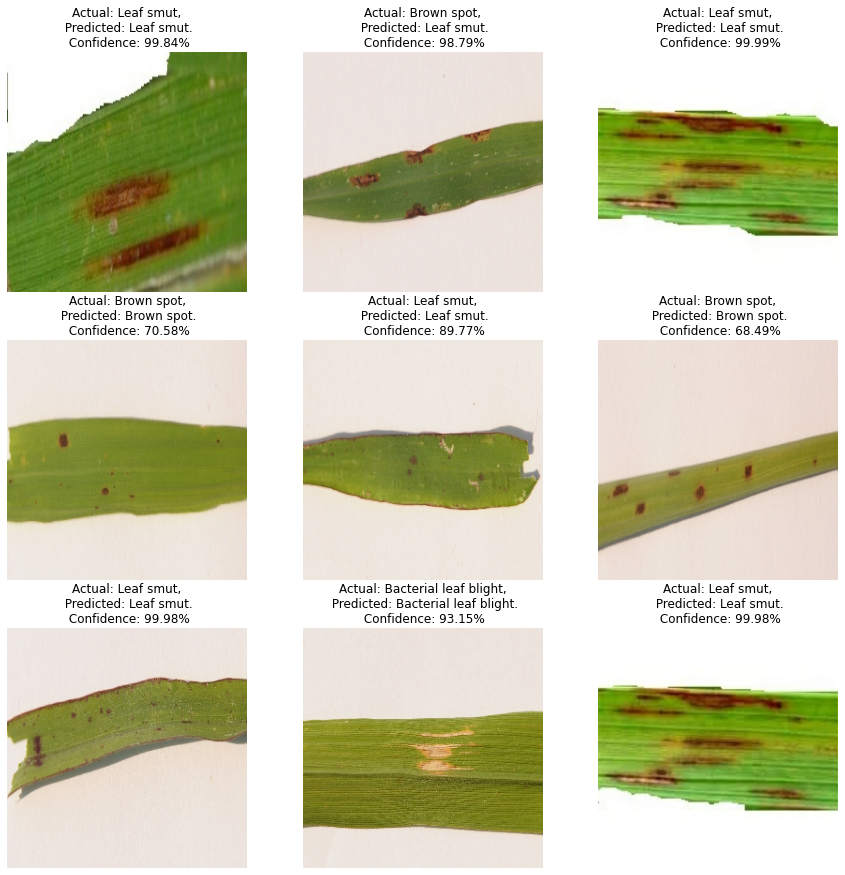

In [32]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving the model

In [33]:
import os, json, h5py
from datetime import datetime

MODEL_PATH = "models"
MODEL_NAME_FMT = "%Y%m%d_%H%M%S"

if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

model_version = datetime.now().strftime(MODEL_NAME_FMT)
model_path = f"{MODEL_PATH}/{model_version}.h5"
model.save(model_path)

# writing class_names
with h5py.File(model_path,'r+') as fp:
  fp.attrs['class_names'] = json.dumps(class_names)